In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

from models.estimators._common import get_default_params

2024-09-09 12:20:27.946988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def get_condition(params, defaults, name):
    if name == 'l1':
        cond = (params['alpha'] == defaults['alpha']) & (params['max_iter'] == defaults['max_iter'])
    elif name == 'l2':
        cond = (params['alpha'] == defaults['alpha']) & (params['max_iter'] == defaults['max_iter'])
    elif name == 'dt':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'rf':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'et':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'kr':
        cond = (params['alpha'] == defaults['alpha']) & (params['gamma'] == defaults['gamma']) & (params['kernel'] == defaults['kernel']) & (params['degree'] == defaults['degree'])
    elif name == 'cb':
        cond = (params['depth'] == defaults['depth']) & (params['l2_leaf_reg'] == defaults['l2_leaf_reg'])
    elif name == 'lgbm':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['reg_lambda'] == defaults['reg_lambda'])
    elif name == 'cf':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    else:
        raise ValueError("Unrecognised 'get_condition' key.")
    
    return cond

def get_base_id(est, bl, ds, defaults, file_prefix):
    model_name = f'{est}_{bl}'
    params = pd.read_csv(f'../results/predictions/{ds}/{model_name}/{file_prefix}_params.csv')
    cond = get_condition(params, defaults, bl)
    return int(params.loc[cond, 'id'])

def get_default_id(est, bl, ds):
    defaults = get_default_params(bl, ds)
    model_name = f'{est}_{bl}'

    if est in ['sl', 'ipsws', 'dmls', 'drs', 'xl']:
        id = get_base_id(est, bl, ds, defaults, model_name)
    elif est == 'tl':
        m0_id = get_base_id(est, bl, ds, defaults, f'{model_name}_m0')
        m1_id = get_base_id(est, bl, ds, defaults, f'{model_name}_m1')
        params = pd.read_csv(f'../results/predictions/{ds}/{model_name}/{model_name}_cate_params.csv')
        id = int(params.loc[(params['m0'] == m0_id) & (params['m1'] == m1_id), 'id'])
    elif est == 'cf':
        params = pd.read_csv(f'../results/predictions/{ds}/{est}/{est}_params.csv')
        cond = get_condition(params, defaults, est)
        id = int(params.loc[cond, 'id'])
    else:
        id = -1
    
    return id

def get_def_perf(est, bl, ds, test, target):
    def_id = get_default_id(est, bl, ds)
    results = test.apply(lambda x: x.loc[x['param_id'] == def_id])
    arr = results.reset_index()[target].to_numpy()
    df = pd.DataFrame(arr, columns=[target])
    df['hyperparameters'] = 'default'
    return df

def metric_by_best(df, by, target, lower_is_better):
    iter_gr = df.groupby(['iter_id'], as_index=False)

    if lower_is_better:
        best_by_iter = iter_gr.apply(lambda x: x.loc[x[by].idxmin(), [target]])
    else:
        best_by_iter = iter_gr.apply(lambda x: x.loc[x[by].idxmax(), [target]])

    return best_by_iter.reset_index()[target].to_numpy()

def get_val_metric(df, target, best):
    return metric_by_best(df, f'{target}_val', f'{target}_test', best)

def get_val_oracle(df, target):
    arr = get_val_metric(df, target, True)
    df = pd.DataFrame(arr, columns=[target])
    df['hyperparameters'] = 'best'
    return df

def parse_est_name(name):
    name = name.upper()
    if name == 'IPSWS':
        return 'IPSW'
    elif name == 'DRS':
        return 'DR'
    elif name == 'DMLS':
        return 'DML'
    else:
        return name
    
def parse_base_name(name):
    name = name.upper()
    if name == 'MLP':
        return 'NN'
    else:
        return name

In [3]:
def get_perfs(ds, target, estimators, base_learners):
    df_main = None

    for est in estimators:
        if est == 'cf':
            df_test = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_test_metrics.csv')
            df_val = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_val_metrics.csv')
            df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
            df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])
            
            iter_gr = df_test.groupby(['iter_id'], as_index=False)
            df_def = get_def_perf(est, est, ds, iter_gr, target)
            df_best = get_val_oracle(df_base, target)
            
            df_est = pd.concat([df_def, df_best])
            df_est['estimator'] = parse_est_name(est)
            df_main = pd.concat([df_main, df_est], axis=0)
        else:
            for bl in base_learners:
                model_name = f'{est}_{bl}'

                try:
                    df_test = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_test_metrics.csv')
                    df_val = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_val_metrics.csv')
                    df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
                    df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])
            
                    iter_gr = df_test.groupby(['iter_id'], as_index=False)
                except:
                    print(f'Missing {model_name}?')
                    continue

                if bl != 'mlp':
                    df_def = get_def_perf(est, bl, ds, iter_gr, target)
                else:
                    df_def = None
                    
                df_best = get_val_oracle(df_base, target)
                
                df_est = pd.concat([df_def, df_best])
                df_est['estimator'] = f'{parse_est_name(est)}-{parse_base_name(bl)}'
                df_main = pd.concat([df_main, df_est], axis=0)

    return df_main

In [4]:
estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb', 'mlp']

#estmators = ['sl', 'tl']
#base_learners = ['dt', 'rf', 'mlp']

## IHDP

Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?
Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?


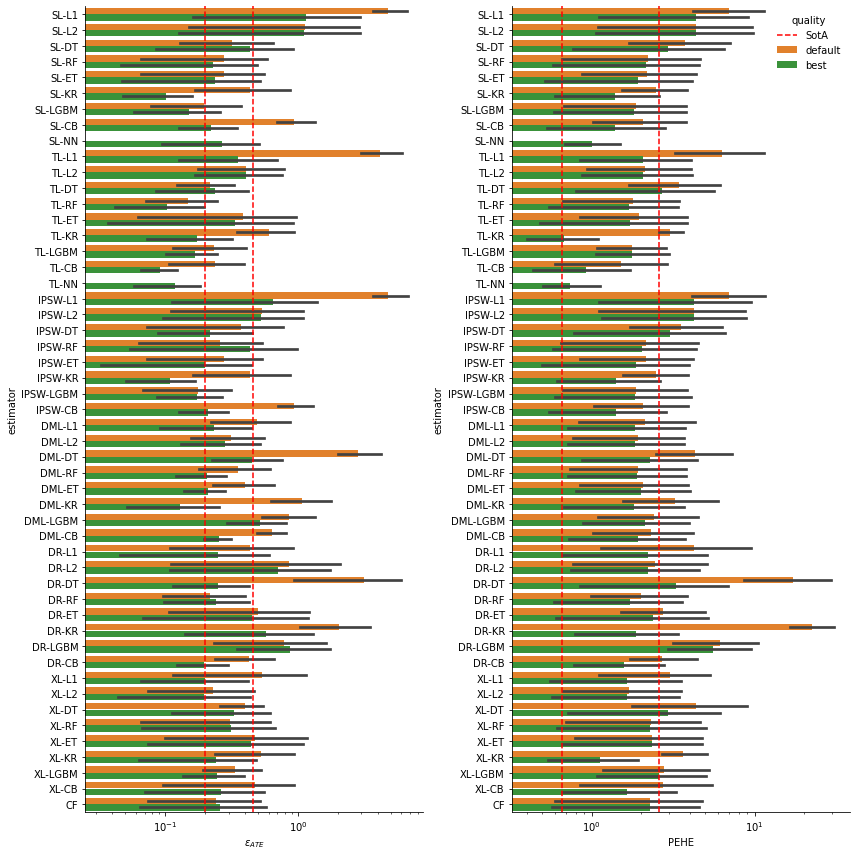

In [14]:
my_pal = ['C1', 'C2']
ds = 'ihdp'
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
target = 'ate'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_xscale('log')
ax.axvline(0.2, ls='dashed', label='SotA', c='r')
ax.axvline(0.46, ls='dashed', label='SotA', c='r')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

ax = axs[1]
target = 'pehe'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel(target.upper())
ax.set_xscale('log')
ax.axvline(0.656, ls='dashed', label='SotA', c='r')
ax.axvline(2.6, ls='dashed', c='r')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

plt.legend(loc='upper right', frameon=False, title='quality', bbox_to_anchor=(1, 1))

plt.tight_layout()
#plt.savefig('ce_bl_ihdp.pdf', dpi=1000)
plt.savefig('ce_bl_ihdp_log.pdf', dpi=1000)

## Jobs

Missing ipsws_et?
Missing ipsws_kr?
Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?
Missing ipsws_et?
Missing ipsws_kr?
Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?


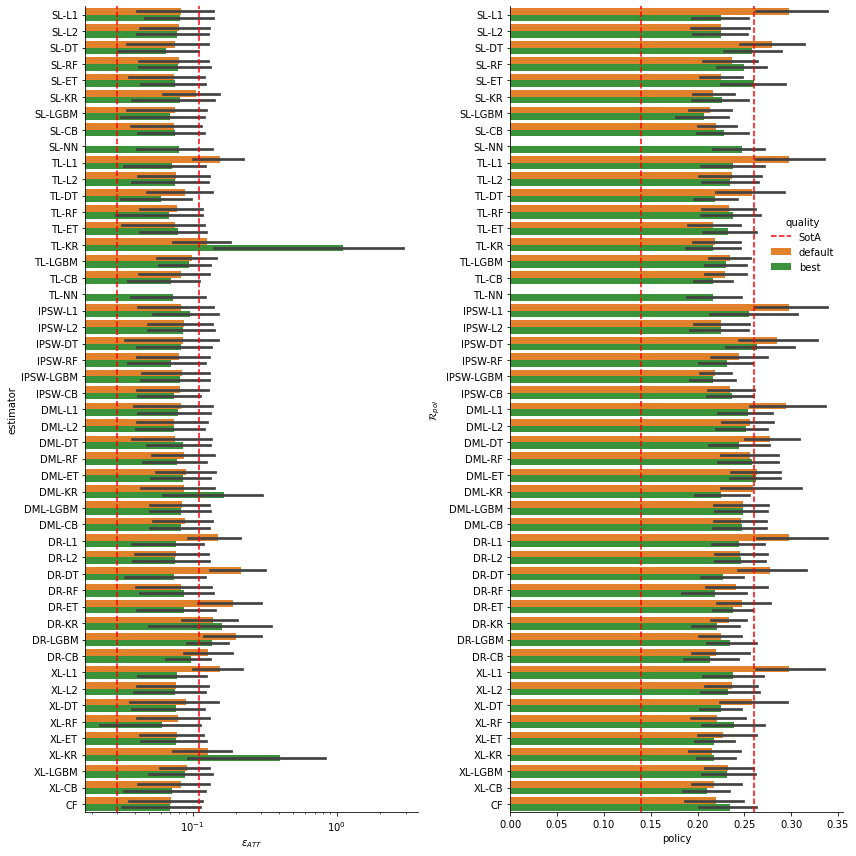

In [11]:
my_pal = ['C1', 'C2']
ds = 'jobs'
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
target = 'att'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_xscale('log')
ax.axvline(0.03, ls='dashed', label='SotA', c='r')
ax.axvline(0.11, ls='dashed', label='SotA', c='r')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

ax = axs[1]
target = 'policy'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel('$\mathcal{R}_{pol}$')
ax.axvline(0.14, ls='dashed', label='SotA', c='r')
ax.axvline(0.26, ls='dashed', c='r')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

plt.legend(loc='upper right', frameon=False, title='quality', bbox_to_anchor=(1, 0.75))

plt.tight_layout()
#plt.savefig('ce_bl_jobs.pdf', dpi=1000)
plt.savefig('ce_bl_jobs_log.pdf', dpi=1000)

## Twins

Missing ipsws_l2?
Missing ipsws_kr?
Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?
Missing ipsws_l2?
Missing ipsws_kr?
Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?


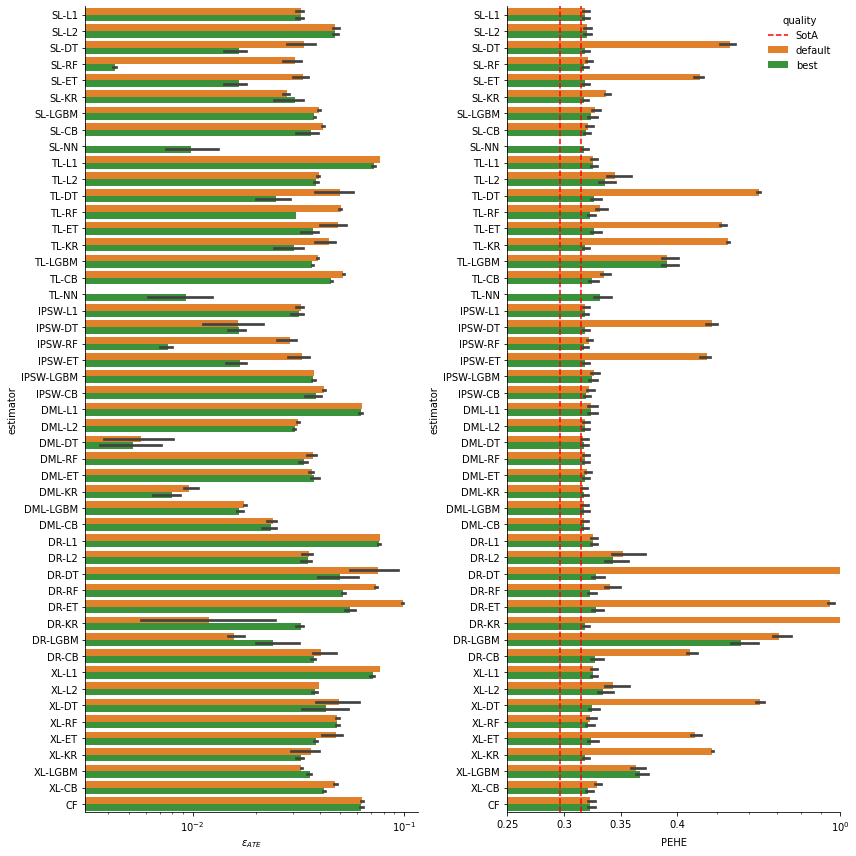

In [19]:
my_pal = ['C1', 'C2']
ds = 'twins'
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
target = 'ate'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_xscale('log')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

ax = axs[1]
target = 'pehe'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel(target.upper())
ax.set_xlim(0.25, 1.0)
ax.set_xscale('symlog', linthresh=0.4, subs=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_xscale('symlog', linthresh=0.3, subs=[2, 4, 6, 8])
#ax.set_xscale('symlog', linthresh=0.4)
ax.set_xticks([0.25, 0.30, 0.35, 0.40, 1], labels=[0.25, 0.30, 0.35, 0.40, '$10^0$'])
ax.axvline(0.297, ls='dashed', label='SotA', c='r')
ax.axvline(0.315, ls='dashed', c='r')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

plt.legend(loc='upper right', frameon=False, title='quality', bbox_to_anchor=(1, 1))

plt.tight_layout()
#plt.savefig('ce_bl_twins.pdf', dpi=1000)
plt.savefig('ce_bl_twins_log.pdf', dpi=1000)

## News

Missing ipsws_l2?
Missing ipsws_kr?
Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?
Missing ipsws_l2?
Missing ipsws_kr?
Missing ipsws_mlp?
Missing dmls_mlp?
Missing drs_mlp?
Missing xl_mlp?


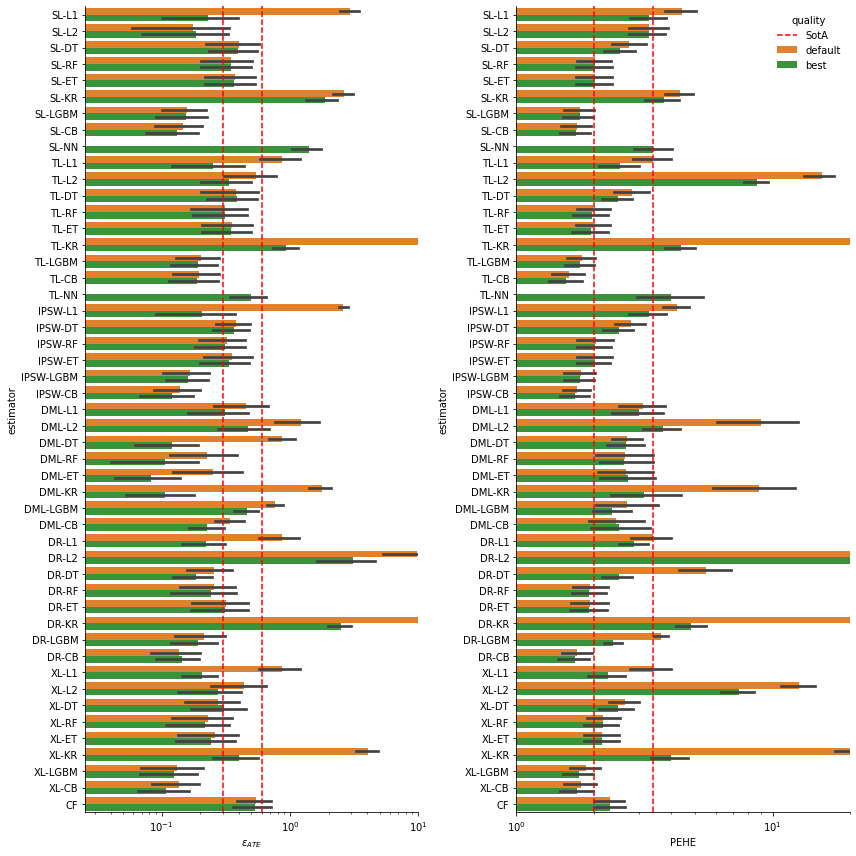

In [26]:
my_pal = ['C1', 'C2']
ds = 'news'
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
target = 'ate'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_xscale('log')
ax.set_xlim(right=10.0)
ax.axvline(0.3, ls='dashed', label='SotA', c='r')
ax.axvline(0.6, ls='dashed', label='SotA', c='r')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

ax = axs[1]
target = 'pehe'
df = get_perfs(ds, target, estmators, base_learners)
sns.barplot(data=df, y='estimator', x=target, hue='hyperparameters', orient='h', ax=ax, palette=my_pal)
ax.set_xlabel(target.upper())
ax.set_xscale('log')
ax.set_xlim(1.0, 20.0)
ax.axvline(2.0, ls='dashed', label='SotA', c='r')
ax.axvline(3.4, ls='dashed', c='r')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().remove()

plt.legend(loc='upper right', frameon=False, title='quality', bbox_to_anchor=(1, 1))

plt.tight_layout()
#plt.savefig('ce_bl_news.pdf', dpi=1000)
plt.savefig('ce_bl_news_log.pdf', dpi=1000)